In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import numpy as np

In [2]:
# training  data增强
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # 水平翻转
    transforms.RandomRotation(15), # 翻转
    transforms.ToTensor(), # 图片 to Tensor，normalize
])
# test transform
test_transform = transforms.Compose([
    transforms.ToTensor(),
])
# 调用预置的dataset

train_set = datasets.MNIST(root=r'G:\研一\深度学习\handwritedigit',
                           transform = train_transform,
                            train = True,
                            download=False
                            )

test_set = datasets.MNIST(root=r'G:\研一\深度学习\handwritedigit',
                           transform = test_transform,
                           train=False
                           )


In [3]:
# load data
train_loader = torch.utils.data.DataLoader(dataset =train_set,
                                                batch_size = 64,
                                                shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset =test_set,
                                                batch_size = 64,
                                                shuffle = False)

tensor([6, 0, 6, 7, 2, 5, 1, 2, 4, 0, 0, 2, 2, 9, 1, 0, 7, 8, 2, 4, 7, 8, 1, 0,
        7, 8, 0, 1, 3, 9, 5, 1, 9, 3, 0, 3, 2, 9, 2, 9, 4, 2, 0, 5, 4, 1, 6, 4,
        0, 1, 6, 4, 6, 5, 2, 7, 5, 2, 4, 1, 6, 6, 5, 3])
[tensor(6), tensor(0), tensor(6), tensor(7), tensor(2), tensor(5), tensor(1), tensor(2), tensor(4), tensor(0), tensor(0), tensor(2), tensor(2), tensor(9), tensor(1), tensor(0), tensor(7), tensor(8), tensor(2), tensor(4), tensor(7), tensor(8), tensor(1), tensor(0), tensor(7), tensor(8), tensor(0), tensor(1), tensor(3), tensor(9), tensor(5), tensor(1), tensor(9), tensor(3), tensor(0), tensor(3), tensor(2), tensor(9), tensor(2), tensor(9), tensor(4), tensor(2), tensor(0), tensor(5), tensor(4), tensor(1), tensor(6), tensor(4), tensor(0), tensor(1), tensor(6), tensor(4), tensor(6), tensor(5), tensor(2), tensor(7), tensor(5), tensor(2), tensor(4), tensor(1), tensor(6), tensor(6), tensor(5), tensor(3)]


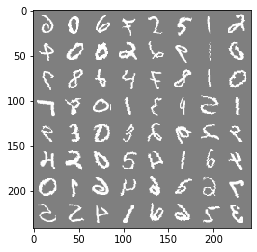

In [4]:
images,labels=next(iter(train_loader))
img = torchvision.utils.make_grid(images)

img = img.numpy().transpose(1,2,0)    # 在matplot中，要将数组转为 （height,weight,chanel)
std = [0.5,0.5,0.5]
mean = [0.5,0.5,0.5]
img = img*std +mean
print(labels)
print([labels[i] for i in range(64)])
plt.imshow(img)

In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        # input  3*28*28
        self.cnn = nn.Sequential(
            nn.Conv2d(1,64,3,1,1),    # 64 28 28
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2,0),     # 64 14 14

            nn.Conv2d(64,128,3,1,1),   # 128 14 14
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2,0),      # 128 7 7


        )

        self.fc = nn.Sequential(
            nn.Linear(128*7*7,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,10)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0],-1)
        return self.fc(out)

In [6]:
model = Model().cuda()
loss = nn.CrossEntropyLoss() # 因為是 classification task，所以 loss 使用 CrossEntropyLoss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # optimizer 使用 Adam
num_epoch = 5

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    model.train() # tarin
    for i, data in enumerate(train_loader):
        optimizer.zero_grad() # 每次backward前清零
        train_pred = model(data[0].cuda()) # 将data用model forward
        batch_loss = loss(train_pred, data[1].cuda()) #  loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
        batch_loss.backward()  # back propagation gradient
        optimizer.step() # 以 optimizer 用 gradient 更新參數值

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            val_pred = model(data[0].cuda())
            batch_loss = loss(val_pred, data[1].cuda())

            val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            val_loss += batch_loss.item()

        #將結果 print 出來
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, num_epoch, time.time()-epoch_start_time, \
             train_acc/train_set.__len__(), train_loss/train_set.__len__(), val_acc/test_set.__len__(), val_loss/test_set.__len__()))

[001/005] 31.62 sec(s) Train Acc: 0.920600 Loss: 0.003836 | Val Acc: 0.968500 loss: 0.001589
[002/005] 30.78 sec(s) Train Acc: 0.970667 Loss: 0.001477 | Val Acc: 0.982300 loss: 0.000841
[003/005] 30.19 sec(s) Train Acc: 0.976767 Loss: 0.001174 | Val Acc: 0.981800 loss: 0.000806
[004/005] 30.09 sec(s) Train Acc: 0.980483 Loss: 0.000972 | Val Acc: 0.987700 loss: 0.000629
[005/005] 30.29 sec(s) Train Acc: 0.981783 Loss: 0.000862 | Val Acc: 0.979800 loss: 0.001017
